In [29]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import os
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [24]:
data_path ="C:/Users/issa/Desktop/TA/3TA/Business Case/store-sales"
sns.set_style('darkgrid')

df_store = pd.read_csv(os.path.join(data_path, 'store.csv'))
df_train = pd.read_csv(os.path.join(data_path, 'train.csv'), low_memory=False)

In [5]:
df_total = pd.merge(df_train, df_store, on='Store')
df_total['Date']=pd.to_datetime(df_total['Date'])

In [7]:
ts=df_train.groupby(['Date']).Sales.sum().reset_index()
ts.head()

,Date,Sales
0,2013-01-01,97235
1,2013-01-02,6949829
2,2013-01-03,6347820
3,2013-01-04,6638954
4,2013-01-05,5951593


Ici on choisi le nombre de semaines dans les données du test:

In [12]:
nb_weeks=6

In [70]:
data_test=ts.iloc[-7*nb_weeks:,]
data_train=ts.iloc[:-7*nb_weeks,]
test_dates=data_test['Date'].values

In [71]:
data_test=data_test.set_index('Date').asfreq('D')
data_train=data_train.set_index('Date').asfreq('D')

<AxesSubplot:xlabel='Date'>

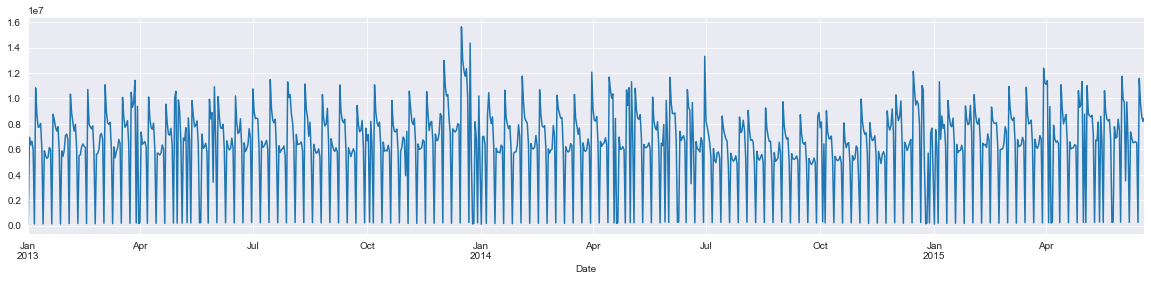

In [72]:
Sales_train = data_train.Sales.copy()
Sales_train.plot(x='Date',y='Sales', figsize=(20,4))

## Holt Winters model

mean absolute error for exponential smoothing model 1186371.1379372247
MAPE for exponential smoothing model 0.5376283902774062


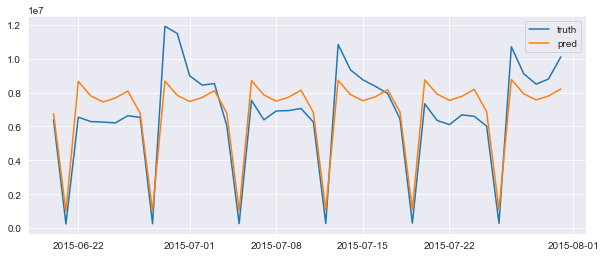

In [73]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#training the model
exp_smooth = ExponentialSmoothing(Sales_train,trend="add",seasonal="add",seasonal_periods=7,missing='raise')
exp_smooth_fit = exp_smooth.fit()

#test of the model
yhat = exp_smooth_fit.predict(test_dates[0],test_dates[-1])

fig, axes = plt.subplots(1, 1,figsize=(10,4))
p1,=axes.plot(data_test)
p2,=axes.plot(yhat)
plt.legend([p1,p2],["truth","pred"])

print(f"mean absolute error for exponential smoothing model {mean_absolute_error(data_test,yhat)}")
print(f"MAPE for exponential smoothing model {mean_absolute_percentage_error(data_test,yhat)}")

## Fourier decomposition

In [106]:
import numpy as np
import pylab as pl
from numpy import fft

def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 10                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 2)         # find linear trend in x
    
    x_notrend = x - p[0] * t    # detrended x
    
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes=pd.Index(indexes).sort_values(key=lambda i: np.absolute(x_freqdom[i]),ascending=False)

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

mean absolute error for fourier decompsition model 2068772.235344128
MAPE for fourier decompsition model 2.1084467139868313


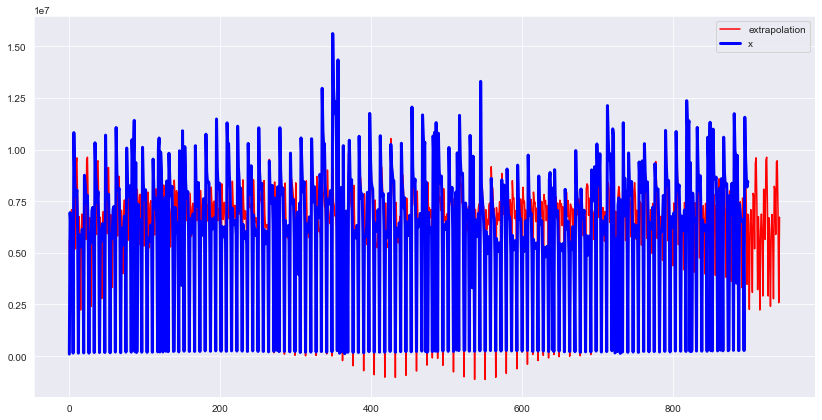

In [107]:
n_predict = 6*7
mask=((ts['Date'].values<'2015-07-07') & (ts['Date'].values>'2015-05-05'))
x=Sales_train
extrapolation = fourierExtrapolation(x, n_predict)
print(f"mean absolute error for fourier decompsition model {mean_absolute_error(data_test,extrapolation[-len(test_dates):])}")
print(f"MAPE for fourier decompsition model {mean_absolute_percentage_error(data_test,extrapolation[-len(test_dates):])}")
pl.figure(figsize=(14,7))
pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
pl.plot(np.arange(0, x.size), x, 'b', label = 'x', linewidth = 3)
pl.legend()
pl.show()

## SARIMA model

In [108]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(20,18), 'figure.dpi':500})
#Original Series
fig, axes = plt.subplots(3, 3, sharex=False)
axes[0, 0].plot(Sales_train); axes[0, 0].set_title('Original Series')
plot_acf(Sales_train, ax=axes[0, 1],lags=32) 
plot_pacf(Sales_train, ax=axes[0, 2],lags=32) 

#1st Differencing
axes[1, 0].plot(Sales_train.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(Sales_train.diff().dropna(), ax=axes[1, 1],lags=32) 
plot_pacf(Sales_train, ax=axes[1, 2],lags=32) 

#2nd Differencing
axes[2, 0].plot(Sales_train.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(Sales_train.diff().diff().dropna(), ax=axes[2, 1],lags=32) 
plot_pacf(Sales_train, ax=axes[2, 2],lags=32) 

plt.show()
plt.rcdefaults()

La série temporelle n'est pas stationnaire à cause des composantes non nulles dans les lags du premier pacf. On doit nécessairement effectuer au moins une différenciation pour annuler la tendance du signal.

In [109]:
# Import library
from pmdarima import auto_arima

# Apply auto_arima to data
sw_fit = auto_arima(Sales_train, start_p = 1, start_q = 1,
                          max_p = 4, max_q = 3,d=1,m=7,
                          start_P = 2,max_P=4,start_Q=3,max_Q=5, seasonal = True,
                            trace = True,
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)#We are using the stepwise approach          
# Summarise the stepwise results
sw_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(2,0,3)[7] intercept   : AIC=29058.964, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=30095.137, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=29417.720, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=29399.739, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=30093.141, Time=0.01 sec
 ARIMA(1,1,1)(1,0,3)[7] intercept   : AIC=29069.023, Time=1.35 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=29058.479, Time=0.94 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=29068.850, Time=0.74 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=29061.030, Time=0.76 sec
 ARIMA(1,1,1)(3,0,2)[7] intercept   : AIC=29057.655, Time=1.65 sec
 ARIMA(1,1,1)(3,0,1)[7] intercept   : AIC=29062.868, Time=1.29 sec
 ARIMA(1,1,1)(4,0,2)[7] intercept   : AIC=29058.240, Time=2.92 sec
 ARIMA(1,1,1)(3,0,3)[7] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(1,1,1)(4,0,1)[7] intercept   : AIC=29058.892, Time=2.38 sec
 ARIMA(1,1,1)(4,0,3)[7] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                  900
Model:             SARIMAX(4, 1, 2)x(4, 0, [1, 2, 3], 7)   Log Likelihood              -14328.371
Date:                                   Mon, 20 Dec 2021   AIC                          28686.743
Time:                                           23:39:41   BIC                          28758.762
Sample:                                                0   HQIC                         28714.256
                                                   - 900                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.236e+04   1.09e+04      1.136      0.256   -8963.570    3.37e+04
ar.L1         -0.8490      0.079    -10.682      0.000      -1.005      -0.693
ar.L2          0.2035      0.102      2.002      0.045       0.004       0.403
ar.L3          0.1931      0.108      1.786      0.074      -0.019       0.405
ar.L4          0.0808      0.064      1.260      0.208      -0.045       0.207
ma.L1          0.0457      0.069      0.666      0.505      -0.089       0.180
ma.L2         -0.9010      0.069    -13.104      0.000      -1.036      -0.766
ar.S.L7       -0.4273      0.355     -1.203      0.229      -1.123       0.269
ar.S.L14       0.3965      0.181      2.192      0.028       0.042       0.751
ar.S.L21       0.7156      0.311      2.304      0.021       0.107       1.324
ar.S.L28       0.2791      0.099      2.808      0.005       0.084       0.474
ma.S.L7        0.2898      0.360      0.806      0.420      -0.415       0.995
ma.S.L14      -0.1925      0.189     -1.019      0.308      -0.563       0.178
ma.S.L21      -0.5500      0.211     -2.608      0.009      -0.963      -0.137
sigma2      6.711e+12      0.000   6.66e+16      0.000    6.71e+12    6.71e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              2212.88
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -1.53
Prob(H) (two-sided):                  0.10   Kurtosis:                        10.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.16e+31. Standard errors may be unstable.
"""

On entraîne un SARIMA avec les paramètres minimisant l'aic.

mean absolute error for SARIMA model 987414.9942132292
MAPE for SARIMA model 0.2057920928368896


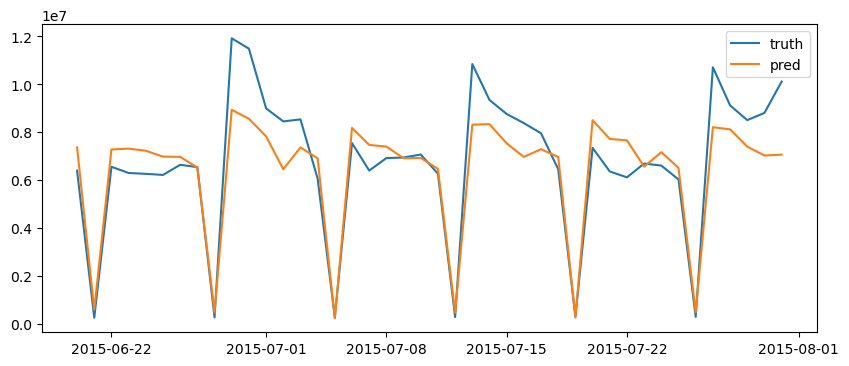

In [110]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#training the model
model = SARIMAX(Sales_train, 
                order = (4,1, 2), 
                seasonal_order =(4, 0, 3, 7))
  
result = model.fit()
result.summary()

#test of the model
start = len(Sales_train)
end = len(Sales_train) + len(test_dates) - 1
pred = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
fig, axes = plt.subplots(1, 1,figsize=(10,4))
p1,=axes.plot(data_test)
p2,=axes.plot(pred)
plt.legend([p1,p2],["truth","pred"])

print(f"mean absolute error for SARIMA model {mean_absolute_error(data_test,pred)}")
print(f"MAPE for SARIMA model {mean_absolute_percentage_error(data_test,pred)}")